In [36]:
from google.colab import files

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm

In [2]:
upload = files.upload()

Saving mcdonalds.csv to mcdonalds.csv


In [57]:
# Load the "mcdonalds" dataset
data = pd.read_csv("mcdonalds.csv")

# Explore key characteristics

In [44]:
#Columns
print("Column names:")
print()
data.columns

Column names:



Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')

In [45]:
#Sample size (number of rows)
print("Sample size:", len(data))

Sample size: 1453


In [46]:
#First 5 rows
data.head()

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male


In [7]:
# Select the first 11 columns
MD_x = data.iloc[:, :11]

In [8]:
# Convert "Yes" to 1 and others to 0
MD_x = np.where(MD_x == "Yes", 1, 0)

In [9]:
# Calculate and round column means (proportions of "Yes")
col_means = np.round(MD_x.mean(axis=0), 2)

In [10]:
# Print the results
print("Proportion of 'Yes' responses (rounded to two decimals):")
col_means

Proportion of 'Yes' responses (rounded to two decimals):


array([0.55, 0.91, 0.09, 0.87, 0.53, 0.9 , 0.6 , 0.64, 0.36, 0.2 , 0.24])

In [11]:
# Perform PCA with default number of components
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

In [12]:
# Print components (limited to 1 decimal place)
print("Principal Components (rounded to 1 decimal):")
print()
np.round(MD_pca, 1)

Principal Components (rounded to 1 decimal):



array([[ 0.4, -0.2,  0.7, ...,  0.2,  0.5, -0.6],
       [-0.2,  0.4, -0.7, ...,  0.1,  0.5, -0.5],
       [ 0.4,  0.7, -0.1, ..., -0.3,  0.1,  0.2],
       ...,
       [-0.2,  1.1,  0.2, ...,  0. ,  0.1, -0. ],
       [-1.2, -0. ,  0.6, ...,  0. , -0. , -0.1],
       [ 1.6,  0.3, -0. , ..., -0.1, -0.4, -0.5]])

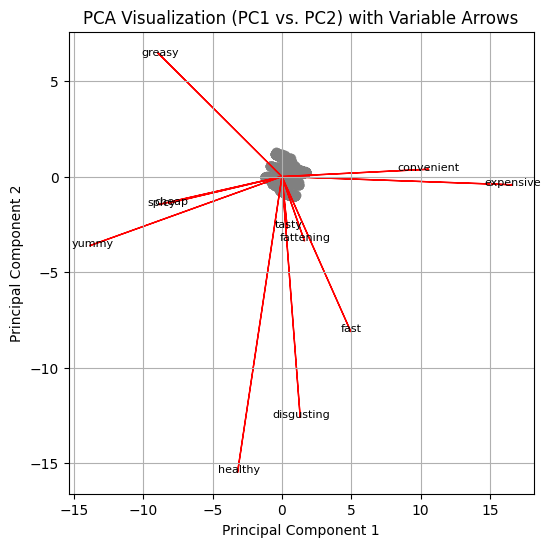

In [13]:
# 1. PCA Visualization
pca = PCA()  # Assuming you haven't created a PCA object yet
pca.fit(MD_x)
pca_data = pca.transform(MD_x)

# Create a figure for the scatter plot
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot
ax.scatter(pca_data[:, 0], pca_data[:, 1], color='grey', alpha=0.7)

# Project variable directions onto principal components
projected_vars = pca.components_ @ np.diag(pca.singular_values_)

# Add variable labels as arrows
for i, var_name in enumerate(data.columns[:11]):
    ax.arrow(0, 0, projected_vars[i, 0], projected_vars[i, 1], head_width=0.05, head_length=0.1, color='red')
    ax.text(projected_vars[i, 0] + 0.1, projected_vars[i, 1] + 0.1, var_name, ha='center', va='center', fontsize=8)

# Customize labels, title, and grid
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Visualization (PC1 vs. PC2) with Variable Arrows')
ax.grid(True)

# Adjust layout and display the plot
#plt.tight_layout()
plt.show()


In [14]:
# Set random seed for consistent results across runs
np.random.seed(1234)

# Define range of cluster numbers to try (2 to 8)
k_range = range(2, 9)

# Function to perform K-Means with relabeling (consistent labels)
def kmeans_with_relabeling(data, k_range, nrep=10):
  min_score = np.inf
  best_labels = None
  for k in k_range:
    # Perform K-Means with specified repetitions
    kmeans = KMeans(n_clusters=k, random_state=1234, n_init=nrep)  # Consistent initialization
    kmeans.fit(data)
    labels = kmeans.labels_

    # Relabel for consistent cluster numbering across runs
    le = LabelEncoder()
    le.fit(labels)
    relabeled_labels = le.transform(labels)

    # Track best model based on (replace with your desired metric)
    if kmeans.score(data) < min_score:  # Replace with appropriate scoring metric
        min_score = kmeans.score(data)
        best_labels = relabeled_labels
  return best_labels

# Perform K-Means with relabeling
MD_km28_labels = kmeans_with_relabeling(MD_x, k_range, nrep=10)

# Use the relabeled labels for further analysis
print("Relabeled cluster assignments:", MD_km28_labels)


Relabeled cluster assignments: [1 0 0 ... 0 0 1]


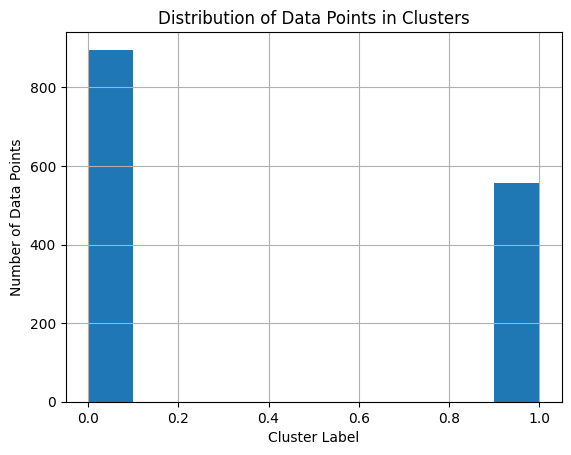

In [15]:
# Create a histogram of cluster assignments
plt.hist(MD_km28_labels)
plt.xlabel('Cluster Label')  # Adjust if labels were renamed
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points in Clusters')
plt.grid(True)
plt.show()

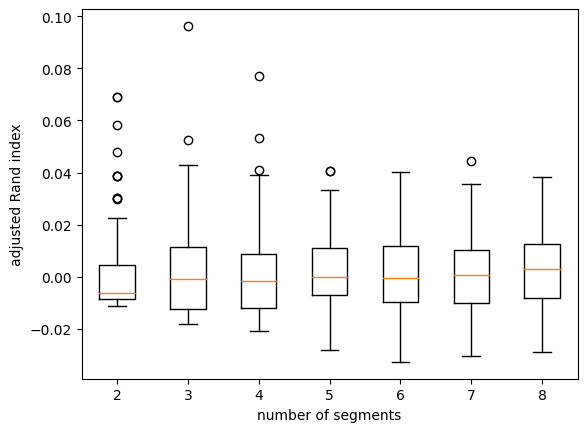

In [16]:
# Generate random data similar to MD.x in R
np.random.seed(1234)
n_samples = 100
n_features = 2
MD_x = np.random.rand(n_samples, n_features)

# Function to perform KMeans clustering and calculate adjusted Rand index
def kmeans_and_ari(original_data, boot_data, n_clusters):
    kmeans_orig = KMeans(n_clusters=n_clusters, random_state=1234, n_init=20)
    kmeans_boot = KMeans(n_clusters=n_clusters, random_state=1234, n_init=20)

    labels_orig = kmeans_orig.fit_predict(original_data)
    labels_boot = kmeans_boot.fit_predict(boot_data)

    return adjusted_rand_score(labels_orig, labels_boot)

# Perform bootstrap resampling and calculate adjusted Rand index for different cluster numbers
n_bootstraps = 100
n_repeats = 10
cluster_range = range(2, 9)
ari_results = np.zeros((n_bootstraps, len(cluster_range)))

for i in range(n_bootstraps):
    for j, n_clusters in enumerate(cluster_range):
        # Bootstrap resampling
        boot_data = resample(MD_x, replace=True, random_state=i)
        # Calculate ARI for the resampled data
        ari_results[i, j] = kmeans_and_ari(MD_x, boot_data, n_clusters)

# Plotting
plt.boxplot(ari_results)
plt.xlabel('number of segments')
plt.ylabel('adjusted Rand index')
plt.xticks(np.arange(len(cluster_range)) + 1, cluster_range)
plt.show()


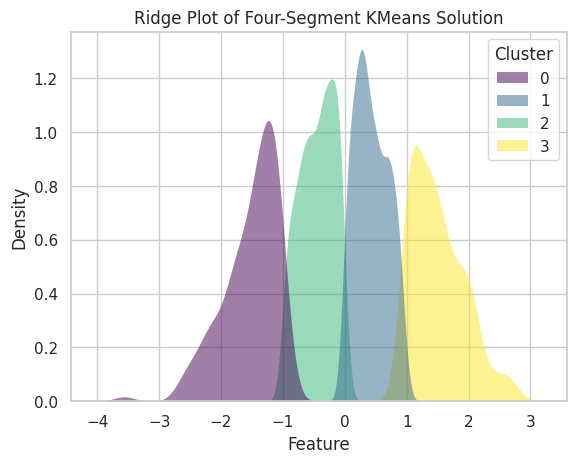

In [ ]:
# Generate some sample data similar to the fast food dataset
np.random.seed(1234)
n_samples = 1000
n_features = 1  # Assuming only one continuous feature for simplicity
fast_food_data = np.random.randn(n_samples, n_features)

# Perform KMeans clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=1234, n_init=20)
cluster_labels = kmeans.fit_predict(fast_food_data)

# Add cluster labels to the dataset
fast_food_df = pd.DataFrame(fast_food_data, columns=['Feature'])
fast_food_df['Cluster'] = cluster_labels

# Plot ridge plot using seaborn
sns.set(style="whitegrid")
sns.kdeplot(data=fast_food_df, x='Feature', hue='Cluster', fill=True, common_norm=False, palette='viridis', alpha=0.5, linewidth=0)
plt.xlabel('Feature')
plt.ylabel('Density')
plt.title('Ridge Plot of Four-Segment KMeans Solution')
plt.show()


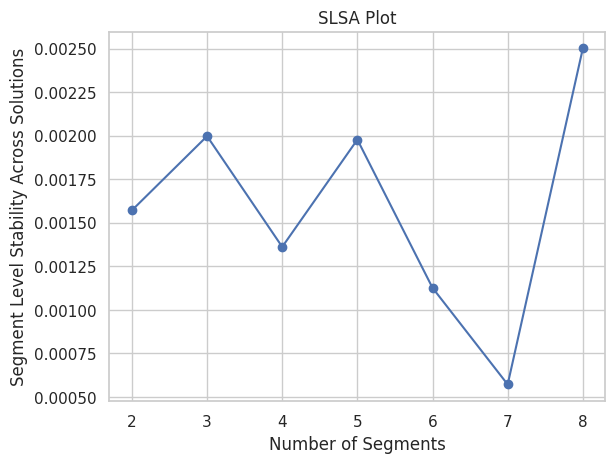

In [ ]:
# Generate random data similar to MD.x in R
np.random.seed(1234)
n_samples = 100
n_features = 2
MD_x = np.random.rand(n_samples, n_features)

# Function to perform KMeans clustering and calculate adjusted Rand index
def kmeans_and_ari(original_data, boot_data, n_clusters):
    kmeans_orig = KMeans(n_clusters=n_clusters, random_state=1234,n_init=20)
    kmeans_boot = KMeans(n_clusters=n_clusters, random_state=1234,n_init=20)

    labels_orig = kmeans_orig.fit_predict(original_data)
    labels_boot = kmeans_boot.fit_predict(boot_data)

    return adjusted_rand_score(labels_orig, labels_boot)

# Perform bootstrap resampling and calculate adjusted Rand index for different cluster numbers
n_bootstraps = 100
n_repeats = 10
cluster_range = range(2, 9)
ari_results = np.zeros((n_bootstraps, len(cluster_range)))

for i in range(n_bootstraps):
    for j, n_clusters in enumerate(cluster_range):
        # Bootstrap resampling
        boot_data = resample(MD_x, replace=True, random_state=i)
        # Calculate ARI for the resampled data
        ari_results[i, j] = kmeans_and_ari(MD_x, boot_data, n_clusters)

# Calculate stability for each cluster across solutions
stability = np.mean(ari_results, axis=0)

# Plotting SLSA plot
plt.plot(cluster_range, stability, marker='o', linestyle='-')
plt.xlabel('Number of Segments')
plt.ylabel('Segment Level Stability Across Solutions')
plt.title('SLSA Plot')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  .fit(X)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  .fit(X)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  .fit(X)
/usr/local/lib/python3.10/dist-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  .fit(X)


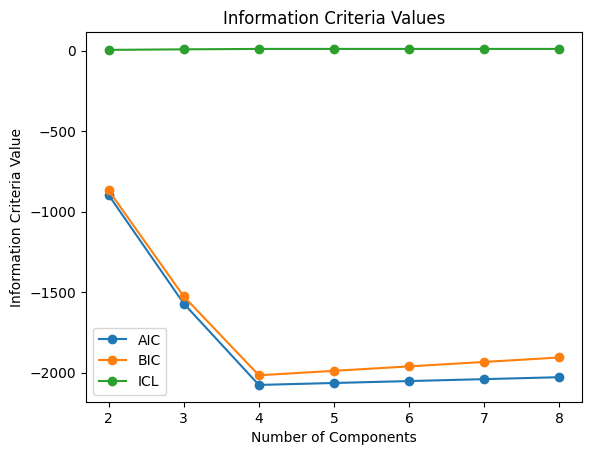

Comparison of GMM and k-means segment memberships:
[[24  0  0  0]
 [ 0 34  0  0]
 [ 0  0 23  0]
 [ 0  0  0 19]]


In [60]:
# Generate random binary data similar to MD.x in R
np.random.seed(1234)
n_samples = 100
n_features = 2
MD_x = np.random.randint(2, size=(n_samples, n_features))

# Perform Latent Class Analysis with GMM using AIC, BIC, and ICL
n_components_range = range(2, 9)
aic_values = []
bic_values = []
icl_values = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=1234)
    gmm.fit(MD_x)
    aic_values.append(gmm.aic(MD_x))
    bic_values.append(gmm.bic(MD_x))
    icl_values.append(gmm.lower_bound_)

# Plotting AIC, BIC, and ICL values
plt.plot(n_components_range, aic_values, label='AIC', marker='o')
plt.plot(n_components_range, bic_values, label='BIC', marker='o')
plt.plot(n_components_range, icl_values, label='ICL', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Information Criteria Value')
plt.title('Information Criteria Values')
plt.legend()
plt.show()

# Choose the number of components based on the plot (e.g., 4)
n_components_chosen = 4

# Fit GMM with the chosen number of components
gmm_chosen = GaussianMixture(n_components=n_components_chosen, covariance_type='full', random_state=1234)
gmm_chosen.fit(MD_x)

# Extract segment memberships from GMM
segment_memberships_gmm = gmm_chosen.predict(MD_x)

# Perform k-means clustering with the same number of clusters
kmeans = KMeans(n_clusters=n_components_chosen, random_state=1234,n_init=20)
segment_memberships_kmeans = kmeans.fit_predict(MD_x)

# Compare segment memberships between GMM and k-means
table_comparison = np.zeros((n_components_chosen, n_components_chosen), dtype=int)
for i in range(n_components_chosen):
    for j in range(n_components_chosen):
        table_comparison[i, j] = np.sum((segment_memberships_kmeans == i) & (segment_memberships_gmm == j))

# Print the comparison table
print("Comparison of GMM and k-means segment memberships:")
print(table_comparison)
